# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [31]:
# Load the libraries as required.
import pandas as pd


In [32]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

print(fires_dt.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   

# Get X and Y

Create the features data frame and target data.

In [33]:
# Define the features (X) and target (Y)
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

# Display the first few rows of X and Y to verify
print("Features (X):")
print(X.head())

print("\nTarget (Y):")
print(Y.head())


Features (X):
   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0

Target (Y):
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Define numerical and categorical features
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

categorical_features = ['month', 'day']

# Preproc 1: Simple processor with standard scaling and one-hot encoding
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [35]:
# Preproc 2: Processor with non-linear transformation and robust scaling
preproc2 = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('num_transformed', PowerTransformer(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Example: Apply the preprocessors to the data
X_preproc1 = preproc1.fit_transform(X)
X_preproc2 = preproc2.fit_transform(X)

# Verify the transformations
# print("Preproc 1 output shape: ", preproc1.shape)
# print("Preproc 2 output shape: ", preproc2.shape)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [36]:
# Pipeline A = preproc1 + baseline

# Baseline Regressor: KNeighbors
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', KNeighborsRegressor())
])



In [37]:
# Pipeline B = preproc2 + baseline
# Baseline Regressor: KNeighbors
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', KNeighborsRegressor())
])

In [38]:
# Pipeline C = preproc1 + advanced model
# Advanced Regressor: RandomForest
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())
])

In [39]:
# Pipeline D = preproc2 + advanced model
# Advanced Regressor: RandomForest
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [40]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Define parameter grids
param_grid_A = {
    'regressor__n_neighbors': [3, 5, 7, 9]
}

param_grid_B = {
    'regressor__n_neighbors': [3, 5, 7, 9]
}

param_grid_C = {
    'regressor__n_estimators': [100, 200, 300, 400],
    'regressor__max_depth': [None, 10, 20, 30]
}

param_grid_D = {
    'regressor__n_estimators': [100, 200, 300, 400],
    'regressor__max_depth': [None, 10, 20, 30]
}

# Define the original scorer 
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def safe_scorer(estimator, X, Y, **score_params):
    try:
        return scorer(estimator, X, Y, **score_params)
    except Exception as e:
        print(f"Scoring failed with exception: {e}")
        return np.nan

# Convert the custom scorer to a compatible format for GridSearchCV 
# custom_scorer = make_scorer(safe_scorer, greater_is_better=False)

# Perform GridSearchCV for each pipeline
grid_search_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring=safe_scorer)
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring=safe_scorer)
grid_search_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring=safe_scorer)
grid_search_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring=safe_scorer)



# Fit the models
grid_search_A.fit(X, Y)
grid_search_B.fit(X, Y)
grid_search_C.fit(X, Y)
grid_search_D.fit(X, Y)

# Print best parameters and scores
print(f'Best parameters for Pipeline A: {grid_search_A.best_params_}')
print(f'Best cross-validated score for Pipeline A: {grid_search_A.best_score_}')

print(f'Best parameters for Pipeline B: {grid_search_B.best_params_}')
print(f'Best cross-validated score for Pipeline B: {grid_search_B.best_score_}')

print(f'Best parameters for Pipeline C: {grid_search_C.best_params_}')
print(f'Best cross-validated score for Pipeline C: {grid_search_C.best_score_}')

print(f'Best parameters for Pipeline D: {grid_search_D.best_params_}')
print(f'Best cross-validated score for Pipeline D: {grid_search_D.best_score_}')


Best parameters for Pipeline A: {'regressor__n_neighbors': 9}
Best cross-validated score for Pipeline A: -5031.7591945117065
Best parameters for Pipeline B: {'regressor__n_neighbors': 9}
Best cross-validated score for Pipeline B: -4972.757453230899
Best parameters for Pipeline C: {'regressor__max_depth': 30, 'regressor__n_estimators': 300}
Best cross-validated score for Pipeline C: -4715.085004851257
Best parameters for Pipeline D: {'regressor__max_depth': 30, 'regressor__n_estimators': 300}
Best cross-validated score for Pipeline D: -4819.472843827484


# Evaluate

+ Which model has the best performance?
Pipeline C performed the best overall with the least negative score, indicating it may generalize better on unseen data compared to the others.

# Export

+ Save the best performing model to a pickle file.

In [41]:
import pickle

# Save the model to a pickle file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(grid_search_C, f)

print("The best performing model has been saved to best_model.pkl.")

The best performing model has been saved to best_model.pkl.


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [42]:
import shap
print(shap.__version__)

0.46.0


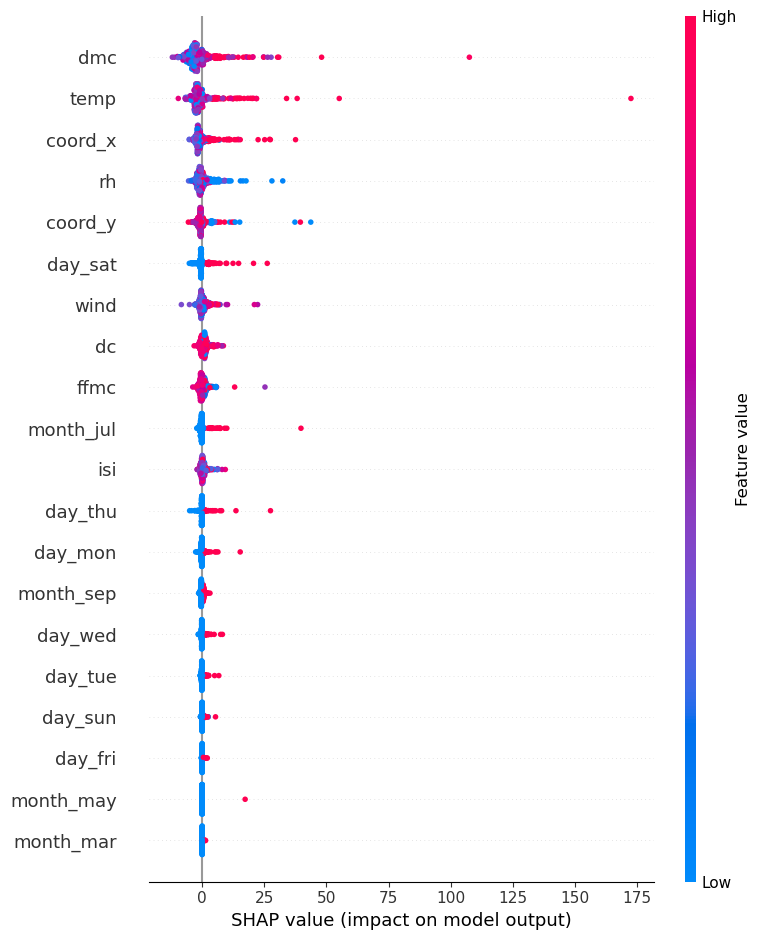

Most important features: [0]
Least important features: [0]
Performance with reduced feature set: 0.006526699683770842


In [43]:
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


# Use SHAP values to explain the best-performing model (Pipeline C in this case)
best_model_pipeline = grid_search_C.best_estimator_

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the best model pipeline on the training data
best_model_pipeline.fit(X_train, Y_train)

# Select an observation from the test set
observation = pd.DataFrame([X_test.iloc[0]], columns=X_test.columns)
observation_transformed = best_model_pipeline.named_steps['preprocessing'].transform(observation)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_model_pipeline.named_steps['regressor'])

# Calculate SHAP values for the observation
shap_values_observation = explainer.shap_values(observation_transformed)

# Plot SHAP values for the observation
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_observation[0], observation_transformed[0], feature_names=observation.columns.tolist())

# Calculate SHAP values for the entire training set
shap_values_train = explainer.shap_values(best_model_pipeline.named_steps['preprocessing'].transform(X_train))

# Get feature names after preprocessing
onehot_categories = grid_search_C.best_estimator_.named_steps['preprocessing'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.hstack([numeric_features, onehot_categories])

# Plot summary plot for feature importance across the training set
shap.summary_plot(shap_values_train, best_model_pipeline.named_steps['preprocessing'].transform(X_train), feature_names=all_features)

# Identify most and least important features based on mean absolute SHAP values
feature_importance = np.abs(shap_values_train[0]).mean(axis=0)
most_important_features = np.argsort(feature_importance)[::-1]
least_important_features = np.argsort(feature_importance)

print("Most important features:", most_important_features)
print("Least important features:", least_important_features)


# Select a subset of features to remove (e.g., least important 2 features)
features_to_remove = least_important_features[:2]
X_train_reduced = np.delete(best_model_pipeline.named_steps['preprocessing'].transform(X_train), features_to_remove, axis=1)
X_test_reduced = np.delete(best_model_pipeline.named_steps['preprocessing'].transform(X_test), features_to_remove, axis=1)

# Retrain the model with reduced feature set
best_model_reduced = RandomForestRegressor(max_depth=20, n_estimators=200)
best_model_reduced.fit(X_train_reduced, Y_train)

# Evaluate performance on the test set with reduced feature set
performance_reduced = best_model_reduced.score(X_test_reduced, Y_test)
print("Performance with reduced feature set:", performance_reduced)

*(Answer here.)*

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.